In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
data = pd.read_table('dataset/googlebooks-eng-all-1gram-20120701-l.gz', sep='\t', header=None, \
                     names=['ngram', 'year', 'match_count', 'volume_count'])
data.head()

,ngram,year,match_count,volume_count
0,L.2.2,1958,1,1
1,L.2.2,1964,1,1
2,L.2.2,1970,1,1
3,L.2.2,1971,2,2
4,L.2.2,1972,4,4


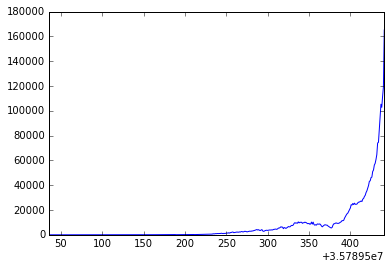

In [3]:
data['volume_count'][data.ngram=='love'].plot()

In [4]:
import nltk
from nltk.corpus import wordnet as wn

see https://en.wikipedia.org/wiki/WordNet for details

In [5]:
wordCloud = wn.synsets('love')
for word in wordCloud:
    for lemma in word.lemmas():
        print lemma

Lemma('love.n.01.love')
Lemma('love.n.02.love')
Lemma('love.n.02.passion')
Lemma('beloved.n.01.beloved')
Lemma('beloved.n.01.dear')
Lemma('beloved.n.01.dearest')
Lemma('beloved.n.01.honey')
Lemma('beloved.n.01.love')
Lemma('love.n.04.love')
Lemma('love.n.04.sexual_love')
Lemma('love.n.04.erotic_love')
Lemma('love.n.05.love')
Lemma('sexual_love.n.02.sexual_love')
Lemma('sexual_love.n.02.lovemaking')
Lemma('sexual_love.n.02.making_love')
Lemma('sexual_love.n.02.love')
Lemma('sexual_love.n.02.love_life')
Lemma('love.v.01.love')
Lemma('love.v.02.love')
Lemma('love.v.02.enjoy')
Lemma('love.v.03.love')
Lemma('sleep_together.v.01.sleep_together')
Lemma('sleep_together.v.01.roll_in_the_hay')
Lemma('sleep_together.v.01.love')
Lemma('sleep_together.v.01.make_out')
Lemma('sleep_together.v.01.make_love')
Lemma('sleep_together.v.01.sleep_with')
Lemma('sleep_together.v.01.get_laid')
Lemma('sleep_together.v.01.have_sex')
Lemma('sleep_together.v.01.know')
Lemma('sleep_together.v.01.do_it')
Lemma('slee